In [205]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import NearMiss

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


import pydotplus 
import graphviz 

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 
sns.set(style="ticks")

import warnings
warnings.filterwarnings("ignore")

In [34]:
data = pd.read_csv("./insurance_dataset.csv")
data.drop('id', axis = 1,inplace=True)

# 1) Предварительный анализ (EDA)

In [35]:
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [36]:
data.isnull().sum() #проверка наличия пропусков

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [37]:
data.dtypes #проверка наличия категориальных признаков

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

Из всех признаков только 3 категориальных, пропусков в данных нет
  
Также посчитаем imbalance ratio(IR), чтобы определить, является ли датасет несбалансированным относительно целевого признака.

In [38]:
balance_table = data['Response'].value_counts()
balance_table

0    334399
1     46710
Name: Response, dtype: int64

In [39]:
IR = balance_table[1]/balance_table[0]
IR

0.13968343206767964

IR примерно равен 0.1, поэтому датасет может считаться несбалансированным и перед обучением моделей нужно будет провести сэмплинг (см. далее)

Визуализируем распределение признаков

In [40]:
d_cols = ['Gender','Driving_License', 'Previously_Insured','Vehicle_Age','Vehicle_Damage']
c_cols = ['Age','Vintage','Annual_Premium','Policy_Sales_Channel','Region_Code']

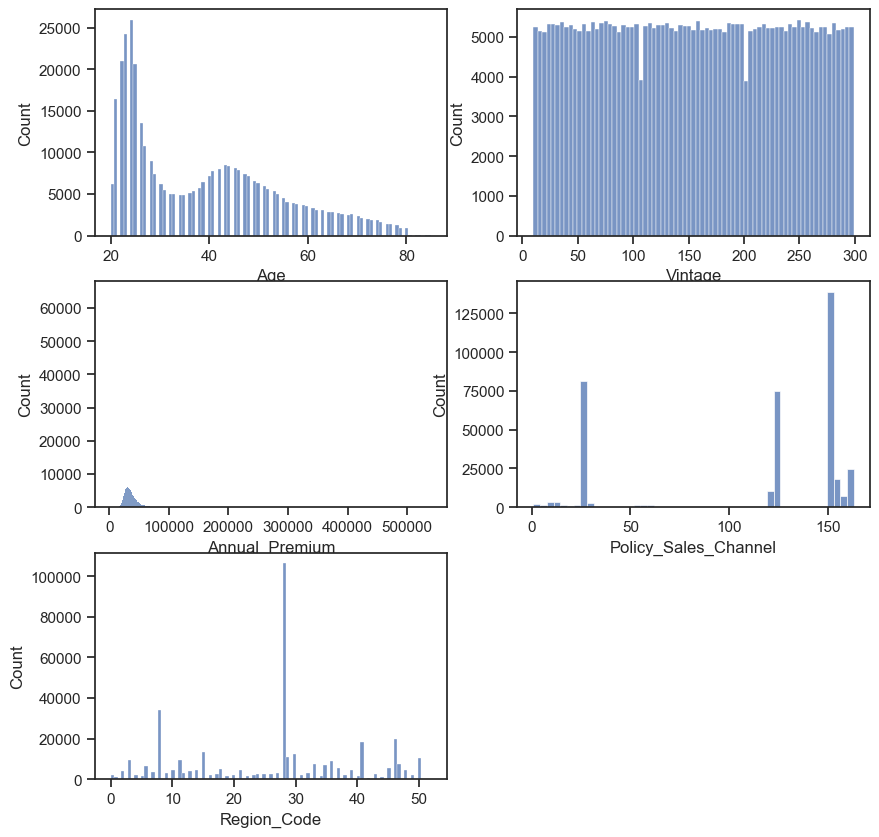

In [41]:
plt.figure(figsize = (10,10))
for i in range(len(c_cols)):
    plt.subplot(3,2,i+1)
    sns.histplot(data[c_cols[i]], kde = False)

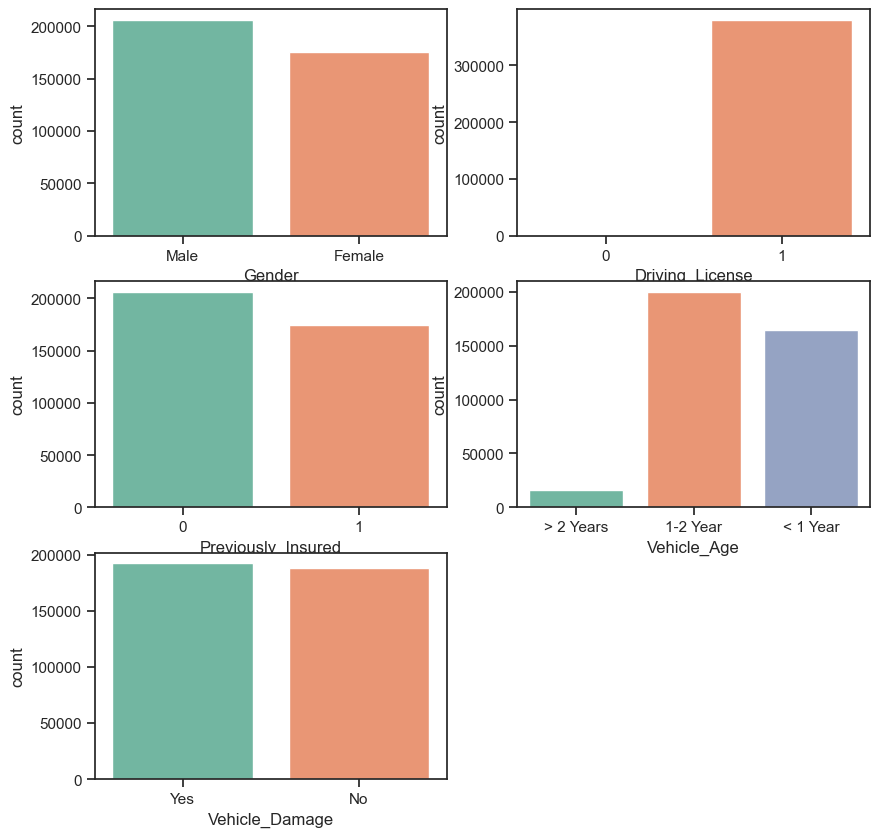

In [42]:
plt.figure(figsize = (10,10))
for i in range(len(d_cols)):
    plt.subplot(3,2,i+1)
    sns.countplot(x = d_cols[i], palette = 'Set2', data = data)

# 2) Обработка данных 

###  Кодирование категориальных признаков

In [43]:
data_coded=data.copy()

Посмотрим, какие уникальные значения есть у каждого категориального признака, чтобы определиться с видом кодирования

In [4]:
for col in ['Gender','Vehicle_Age','Vehicle_Damage']:
    print(col, data[col].unique())

Gender ['Male' 'Female']
Vehicle_Age ['> 2 Years' '1-2 Year' '< 1 Year']
Vehicle_Damage ['Yes' 'No']


Бинарные признаки Gender и Vehicle_Damage закодируем как 0 и 1

In [44]:
data_coded['Gender']=data_coded['Gender'].map({"Male": 1, "Female": 0})
data_coded['Vehicle_Damage']=data_coded['Vehicle_Damage'].map({"Yes": 1, "No": 0})

Для признака Vehicle_Age можно использовать несколько видов кодирования. Признак имеет в своей основе явный порядок, соответствующий увеличению возраста транспортного средства. Label encoding сопоставляет числа категориям случайным образом и может создать ложный порядок, а One hot encoding расширяет пространство признаков и в целом здесь не является необходимым, поэтому более логичным будет присваивание категориям значений согласно заложенному порядку: 0 для категории '< 1 Year', 1 для категории '1-2 Year', 2 для категории '> 2 Years'

In [45]:
data_coded['Vehicle_Age']=data_coded['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

In [7]:
data_coded.dtypes

Gender                    int64
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age               int64
Vehicle_Damage            int64
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

### Обработка выбросов

In [46]:
data_without_outliers = data_coded.copy()

Рассматриваем только колонки 'Annual_Premium', 'Age' и 'Vintage', поскольку остальные являются категориальными или псевдокатегориальными

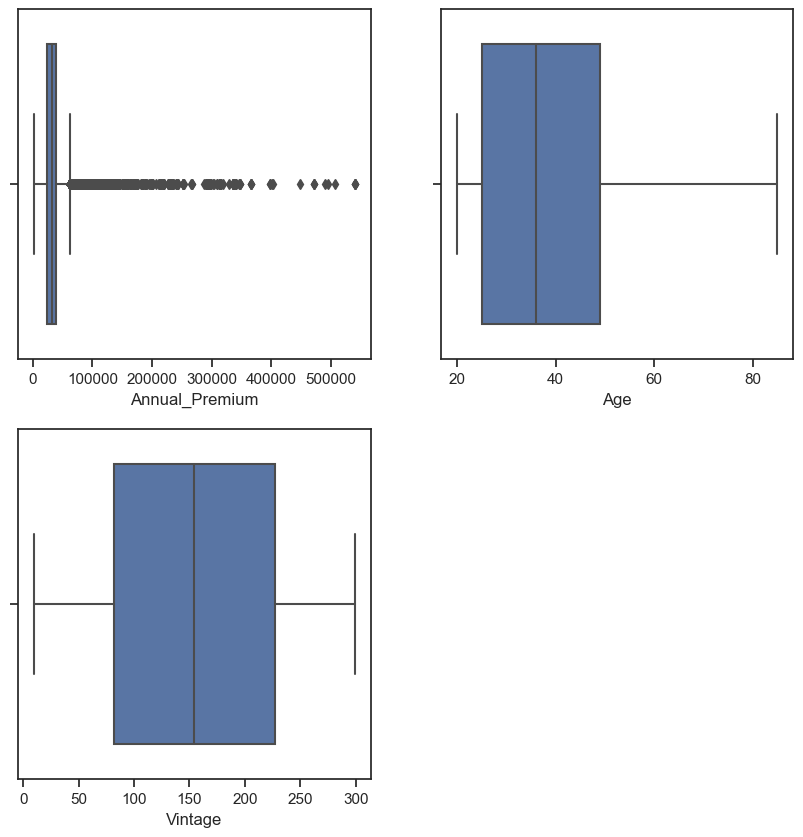

In [9]:
plt.figure(figsize = (10,10))
cols = ['Annual_Premium','Age', 'Vintage']

for i in range(len(cols)):
    plt.subplot(2,2,i+1)
    sns.boxplot(x=cols[i], data=data_coded)
    
plt.show()

Посмотрим, каков процент выбросов у признака 'Annual_Premium'

In [47]:
Q1 = data_coded['Annual_Premium'].quantile(q=.25)
Q3 = data_coded['Annual_Premium'].quantile(q=.75)
IQR = Q3-Q1
data_outliers=data_coded[(data_coded['Annual_Premium'] < (Q1-1.5*IQR)) | (data_coded['Annual_Premium'] > (Q3+1.5*IQR))]
print('Процент выбросов равен', (data_outliers.shape[0]/data_coded.shape[0])*100)

Процент выбросов равен 2.70788672007221


Заменим выбросы на крайние значения, вычисляемые с помощью межквартильного размаха IQR

<AxesSubplot:xlabel='Annual_Premium'>

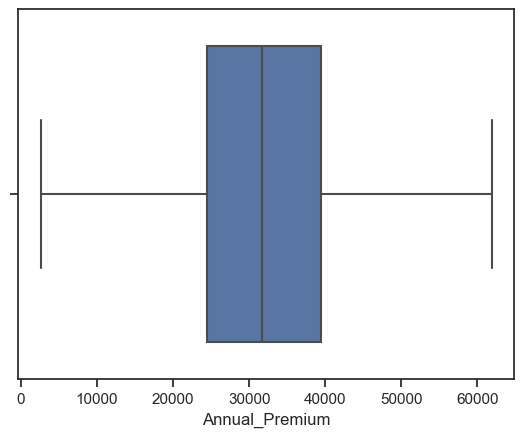

In [48]:
def f_1(Annual_Premium):
    if Annual_Premium<(Q1-1.5*IQR):
        return Q1-1.5*IQR
    elif Annual_Premium>(Q3+1.5*IQR):
        return Q3+1.5*IQR
    else:
        return Annual_Premium
data_with_modified_outliers=data_coded['Annual_Premium'].apply(f_1)
sns.boxplot(x=data_with_modified_outliers,fliersize=0.2)

In [49]:
data_without_outliers.drop('Annual_Premium',axis=1,inplace=True)
data_without_outliers['Annual_Premium']=list(data_with_modified_outliers)

### Масштабирование

In [50]:
data_scaled = data_without_outliers.copy()

Посмотрим, какие признаки необходимо отмасштабировать

In [51]:
data_scaled.agg(['min', 'max'])

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Vintage,Response,Annual_Premium
min,0,20,0,0.0,0,0,0,1.0,10,0,2630.0
max,1,85,1,52.0,1,2,1,163.0,299,1,61892.5


In [52]:
cols_to_scale=['Age','Region_Code','Vehicle_Age','Policy_Sales_Channel','Vintage','Annual_Premium']

In [53]:
for col in cols_to_scale:
    sc = MinMaxScaler()
    data_scaled[[col]]=list(sc.fit_transform(data_scaled[[col]]))

In [54]:
data_scaled.agg(['min', 'max'])

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Vintage,Response,Annual_Premium
min,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0,0.0
max,1,1.0,1,1.0,1,1.0,1,1.0,1.0,1,1.0


### Отбор признаков

*1) Отбор на основе корреляции признаков между собой и с целевой переменной*

<AxesSubplot:>

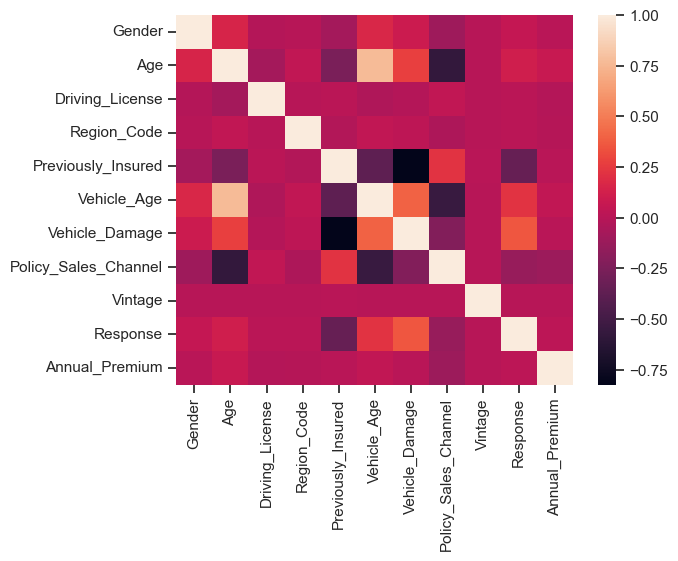

In [26]:
sns.heatmap(data_scaled.corr(), fmt='.3f')

Среди признаков нет сильно коррелирующих между собой (>0.9 по модулю), поэтому нельзя удалить какие-то признаки по этой причине. Интересно, что достаточно сильно коррелируют между собой возраст клиента и возраст его автомобиля, а также наблюдается отрицательная корреляция между наличием опыта страхования автомобиля и наличием повреждений у машины в прошлом.    

С целевой переменной Response сильнее всего коррелирует то, страховал ли уже клиент свою машину, возраст машины и наличие у нее повреждений в прошлом. Посмотрим, какие признаки меньше всего коррелируют с целевой переменной:

In [27]:
response_correlations=data_scaled.corr()['Response']
abs(response_correlations).sort_values()

Vintage                 0.001050
Driving_License         0.010155
Region_Code             0.010570
Annual_Premium          0.022054
Gender                  0.052440
Age                     0.111147
Policy_Sales_Channel    0.139042
Vehicle_Age             0.221874
Previously_Insured      0.341170
Vehicle_Damage          0.354400
Response                1.000000
Name: Response, dtype: float64

Здесь это Vintage, Driving_Licence, Region_Code, Annual_Premium и Gender

*2) Отбор на основе значений коэффициентов признаков при обучении логистической регрессии с L1-регуляризацией*

In [28]:
X = data_scaled.drop('Response',axis=1)
y = data_scaled['Response']
e_lr1 = LogisticRegression(solver='liblinear', penalty='l1', random_state=1)
e_lr1.fit(X,y)

LogisticRegression(penalty='l1', random_state=1, solver='liblinear')

In [29]:
abs(pd.Series(e_lr1.coef_[0], index=X.columns)).sort_values()

Vintage                 0.003894
Region_Code             0.021137
Annual_Premium          0.099080
Gender                  0.104531
Policy_Sales_Channel    0.471675
Driving_License         0.990478
Age                     1.297012
Vehicle_Age             1.380880
Vehicle_Damage          2.019846
Previously_Insured      4.000112
dtype: float64

Тут наименьшие коэффициенты у Vintage, Region_Code, Annual_Premium и Gender

*3) Выявление важности признаков с помощью random forest'а*

In [30]:
rfc1 = RandomForestClassifier(n_estimators=10, random_state=17)
rfc1.fit(X,y)

RandomForestClassifier(n_estimators=10, random_state=17)

In [31]:
abs(pd.Series(rfc1.feature_importances_, index=X.columns)).sort_values()

Driving_License         0.000544
Gender                  0.013757
Vehicle_Age             0.020399
Previously_Insured      0.039205
Policy_Sales_Channel    0.059752
Vehicle_Damage          0.088283
Region_Code             0.103862
Age                     0.144232
Annual_Premium          0.244084
Vintage                 0.285881
dtype: float64

Наименее важные признаки - Driving_License и Gender, в то время как признаки Vintage, Region_Code и Annual_Premium, обозначенные как самые слабые в п.1 и п.2, считаются наиболее важными.

Исходя из результатов трех методов отбора признаков, удалим признаки Gender и Driving_License, как наименее существенные.

In [55]:
data_clean = data_scaled.copy()

In [56]:
data_clean.drop('Gender',axis=1,inplace=True)
data_clean.drop('Driving_License',axis=1,inplace=True)

In [57]:
data_clean.shape

(381109, 9)

### Разделение на X и y

In [207]:
y = data_clean['Response'].astype("int").values
X = data_clean.drop("Response",axis=1).values

In [208]:
X.shape, y.shape

((381109, 8), (381109,))

Разделим выборку на тренировочную и тестовую части

In [209]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify = y)

### Undersampling  
Для undersampling'а выберем стратегию NearMiss-3: будут удаляться экземпляры мажоритарного класса, находящиеся ближе всего к экземплярам миноритарного, то есть у разделяющей границы. Такие экземпляры не сильно улучшают качество классификации, поэтому могут быть удалены

In [211]:
undersample = NearMiss(version=3)
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [212]:
X_train.shape, y_train.shape

((74736, 8), (74736,))

Теперь датасет сбалансирован в пропорции 1:1

In [213]:
pd.Series(y_train).value_counts()

0    37368
1    37368
dtype: int64

# Выбор модели

Для каждой модели будем использовать кросс-валидацию с разбиением на 5 фолдов и стратификацией, чтобы в каждом фолде сохранялось соотношение классов

In [143]:
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

### Выбор метрики для сравнения моделей

Если бы для компании важнее всего было правильно определить всех заинтересованных клиентов, чтобы при проведении маркетинговой кампании включить их в целевую группу, нужно было бы выбрать recall в качестве главной метрики и минимизировать количество ошибок 2 рода. Тем не менее, это неизвестно точно и поэтому главной метрикой будет accuracy. Также для полноты сравнения качества моделей будем рассматривать precision и recall

### Логистическая регрессия

In [253]:
%%time
logit_rand_searcher = RandomizedSearchCV(
    LogisticRegression(), param_distributions = [{'C': np.logspace(-3, 1, 500)}], n_iter = 30,
    cv=cv, n_jobs=None, scoring='accuracy'
)
logit_rand_searcher.fit(X_train, y_train)

Wall time: 17.9 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=LogisticRegression(), n_iter=30,
                   param_distributions=[{'C': array([1.00000000e-03, 1.01862899e-03, 1.03760502e-03, 1.05693455e-03,
       1.07662418e-03, 1.09668060e-03, 1.11711065e-03, 1.13792129e-03,
       1.15911962e-03, 1.18071285e-03, 1.20270833e-03, 1.22511358e-03,
       1.24793621e-03, 1.2...
       6.54080591e+00, 6.66265452e+00, 6.78677305e+00, 6.91320378e+00,
       7.04198979e+00, 7.17317494e+00, 7.30680395e+00, 7.44292233e+00,
       7.58157646e+00, 7.72281357e+00, 7.86668179e+00, 8.01323013e+00,
       8.16250851e+00, 8.31456781e+00, 8.46945981e+00, 8.62723729e+00,
       8.78795401e+00, 8.95166472e+00, 9.11842520e+00, 9.28829225e+00,
       9.46132376e+00, 9.63757866e+00, 9.81711702e+00, 1.00000000e+01])}],
                   scoring='accuracy')

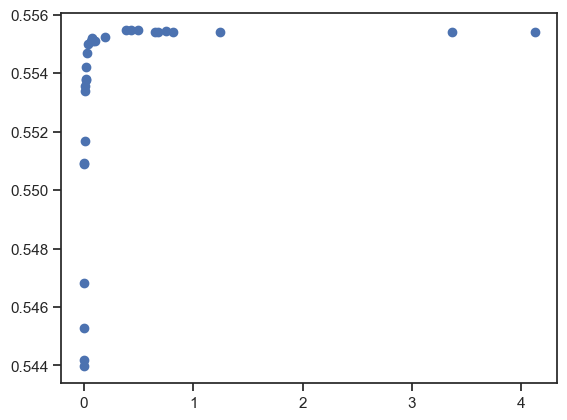

In [254]:
plt.scatter(logit_rand_searcher.cv_results_['param_C'].data, logit_rand_searcher.cv_results_['mean_test_score'])

In [255]:
logit_rand_searcher.best_params_, logit_rand_searcher.best_score_

({'C': 0.4936132098237912}, 0.5554752302126688)

In [256]:
logit_rand_searcher.best_estimator_.fit(X_train,y_train)

LogisticRegression(C=0.4936132098237912)

In [257]:
y_pred = logit_rand_searcher.best_estimator_.predict(X_test)

In [259]:
logit_metrics = pd.Series([
      accuracy_score(y_test, y_pred),
      precision_score(y_test, y_pred),
      recall_score(y_test, y_pred)],
      index=['accuracy','precision','recall'],
      name='Метрики для логистической регрессии')
logit_metrics

accuracy     0.764897
precision    0.285206
recall       0.609613
Name: Метрики для логистической регрессии, dtype: float64

### Random Forest

In [264]:
%%time
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [3,5,7,9,11],
               'min_samples_leaf': [4, 6, 8],
               'n_estimators': [100,200,300]}

model = RandomizedSearchCV(estimator = RandomForestClassifier(max_features=3),
                           param_distributions = random_search,
                           n_iter = 10, cv = cv, verbose= 1, random_state= 101,scoring='accuracy')
model.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 8min 20s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=RandomForestClassifier(max_features=3),
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 7, 9, 11],
                                        'min_samples_leaf': [4, 6, 8],
                                        'n_estimators': [100, 200, 300]},
                   random_state=101, scoring='accuracy', verbose=1)

In [265]:
model.best_params_, model.best_score_

({'n_estimators': 200,
  'min_samples_leaf': 8,
  'max_depth': 11,
  'criterion': 'gini'},
 0.6478002160125531)

In [266]:
model.best_estimator_.fit(X_train,y_train)
y_pred = model.best_estimator_.predict(X_test)

In [267]:
forest_metrics = pd.Series([
      accuracy_score(y_test, y_pred),
      precision_score(y_test, y_pred),
      recall_score(y_test, y_pred)],
      index=['accuracy','precision','recall'],
      name='Метрики для random forest')
forest_metrics

accuracy     0.805620
precision    0.305307
recall       0.459431
Name: Метрики для random forest, dtype: float64

### Градиентный бустинг

In [260]:
%%time
random_search = {'max_depth': [3,5,7,9,11],
        'learning_rate': [0.001, 0.01, 0.1, 1.0],
        'n_estimators': [50,100,150,200]}
model = GridSearchCV(LGBMClassifier(),
                    random_search,
                    cv = cv, verbose= 1, n_jobs = None, scoring = 'accuracy')
model.fit(X_train,y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Wall time: 2min 12s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'max_depth': [3, 5, 7, 9, 11],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy', verbose=1)

In [261]:
model.best_params_, model.best_score_

({'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 50},
 0.653473529045335)

In [262]:
model.best_estimator_.fit(X_train,y_train)
y_pred = model.best_estimator_.predict(X_test)

In [263]:
lgbm_metrics = pd.Series([
      accuracy_score(y_test, y_pred),
      precision_score(y_test, y_pred),
      recall_score(y_test, y_pred)],
      index=['accuracy','precision','recall'],
      name='Метрики для lgbm')
lgbm_metrics

accuracy     0.806631
precision    0.308875
recall       0.466817
Name: Метрики для lgbm, dtype: float64

# Вывод

Таким образом, градиентный бустинг имеет наиболее высокие показатели accuracy (80,7%) и может быть выбран в качестве модели для предсказания заинтересованности клиентов страховой компании в приобретении дополнительных услуг